# Model 3: Improvement

The purpose of this model is to utilize reinforcement learning to improve the prediction capabilities of Model 2 

## Preliminary Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import nbimporter
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

### ACTOR Model Architecture

In [2]:
class Actor(nn.Module):
    
    def __init__(self, num_features):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) # Use ReLU
        x = self.fc2(x)
        return F.softmax(x, dim = -1)

In [3]:
# class Actor(nn.Module):
    
#     def __init__(self, num_features):
#         super(Actor, self).__init__()
#         self.fc1 = nn.Linear(num_features, 128)
#         self.fc2 = nn.Linear(128, 5)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        
#         return F.softmax(x, dim=-1)

### CRITIC Model Architecture

In [4]:
class Critic(nn.Module):
    
    def __init__(self, num_features):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) # Use ReLU
        x = self.fc2(x)
        return F.softmax(x, dim = -1)

### ACTOR Functions

In [5]:
def train_actor(model, optimizer, X_train, y_train, epochs):
    loss_list = []
    
    for epoch in range(epochs):
        optimizer.zero_grad() # Resets gradients
        outputs = model(X_train) # Forward Propagation
        loss = F.cross_entropy(outputs, y_train) # Calculate loss using cross-entropy
        loss.backward() # Backward Propagation
        optimizer.step() # Updates params
        
        loss_list.append(loss.item())
        
        print(f"Epoch {epoch}: Loss = {loss.item()}")
        
    return loss_list

In [6]:
def evaluate_actor(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)

    # Calculate train and test accuracy
    train_accuracy = accuracy_score(y_train, train_predicted)
    print(f'Train Accuracy: {train_accuracy}')
    
    test_accuracy = accuracy_score(y_test, test_predicted)
    print(f'Test Accuracy: {test_accuracy}')

    return train_accuracy, test_accuracy

In [7]:
def predict_action(model, X_input, valid):
    with torch.no_grad():
        output = model(X_input)
        
    valid_tensor = torch.tensor(valid, dtype = torch.bool)
    valid_output = torch.where(valid_tensor, output, torch.tensor(float('-inf')).to(output.dtype))
    
    random_choice = random.randint(1, 5)
    
    if random_choice == 1:
        _, predicted_action = torch.where(valid_output != float('-inf'))
        return np.random.choice(predicted_action).item()
    else:
        _, predicted_action = torch.max(valid_output, 1)
        return predicted_action.item()

In [8]:
def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### CRITIC Functions

In [ ]:
def train_critic(model, optimizer, X_train, y_train, epochs):
    loss_list = []
    
    for epoch in range(epochs):
        optimizer.zero_grad() # Resets gradients
        outputs = model(X_train) # Forward Propagation
        loss = F.cross_entropy(outputs, y_train) # Calculate loss using cross-entropy
        loss.backward() # Backward Propagation
        optimizer.step() # Updates params
        
        loss_list.append(loss.item())
        
        print(f"Epoch {epoch}: Loss = {loss.item()}")
        
    return loss_list

In [ ]:
def evaluate_critic(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)

    # Calculate train and test accuracy
    train_accuracy = accuracy_score(y_train, train_predicted)
    print(f'Train Accuracy: {train_accuracy}')
    
    test_accuracy = accuracy_score(y_test, test_predicted)
    print(f'Test Accuracy: {test_accuracy}')

    return train_accuracy, test_accuracy

### Pretraining Data Preprocessing

In [9]:
pretrain_data = pd.read_csv('Data/Model3/pretraining_data_raw.csv')

In [10]:
pretrain_data = pretrain_data.drop_duplicates()

In [11]:
X_pt = pretrain_data.iloc[:, :-1]
y_pt = pretrain_data.iloc[:, -1]

In [12]:
X_pt

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,d_crew_up,d_crew_down,d_crew_left,d_crew_right,d_crew_stay,alien_detected,crew_detected
0,6,27,0.0,0.0,0.0,0.0,0.0,0.000000,0.001637,0.000000,0.001637,0.000000,0.045455,0.000000,0.045455,0.043478,0,1
1,7,27,0.0,0.0,0.0,0.0,0.0,0.001813,0.000000,0.000000,0.000000,0.333333,0.000000,1.000000,0.000000,0.500000,0,1
2,7,26,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.020408,0.020000,0,0
4,7,26,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.020408,0.020000,0,1
5,7,27,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.019231,0.000000,0.019608,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220562,19,14,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005951,0.000000,0.000000,0.000000,0.166667,0.125000,0.142857,0,1
3220563,18,14,0.0,0.0,0.0,0.0,0.0,0.005989,0.005989,0.006576,0.000000,0.142857,0.142857,0.200000,0.142857,0.166667,0,1
3220564,17,14,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006522,0.000000,0.000000,0.000000,0.250000,0.166667,0.200000,0,1
3220565,16,14,0.0,0.0,0.0,0.0,0.0,0.006633,0.006307,0.000000,0.000000,0.333333,0.200000,0.000000,0.200000,0.250000,0,1


In [13]:
# n_components = 200
# pca = PCA(n_components=n_components)
# pca.fit(X_pt)
# X_pt = pca.transform(X_pt)
# X_pt

In [14]:
# X_pt = pd.DataFrame(X_pt, columns=[f'PC{i+1}' for i in range(X_pt.shape[1])])

In [15]:
y_pt

0          [0, 0, 0, 1, 0]
1          [0, 1, 0, 0, 0]
2          [0, 0, 0, 0, 1]
4          [1, 0, 0, 0, 0]
5          [0, 0, 0, 0, 1]
                ...       
3220562    [0, 0, 1, 0, 0]
3220563    [0, 0, 1, 0, 0]
3220564    [0, 0, 1, 0, 0]
3220565    [0, 1, 0, 0, 0]
3220566    [0, 0, 1, 0, 0]
Name: chosen_action, Length: 1180242, dtype: object

In [16]:
# X_pt = X_pt.drop(columns=['crew_stay'])

In [17]:
crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right']
X_pt['sum_crew'] = X_pt[crew_columns].sum(axis=1)

for col in crew_columns:
    X_pt.loc[X_pt['sum_crew'] != 0, col] = X_pt[col] / X_pt['sum_crew']

X_pt.drop('sum_crew', axis=1, inplace=True)

X_pt

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,d_crew_up,d_crew_down,d_crew_left,d_crew_right,d_crew_stay,alien_detected,crew_detected
0,6,27,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.5,0.000000,0.045455,0.000000,0.045455,0.043478,0,1
1,7,27,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.333333,0.000000,1.000000,0.000000,0.500000,0,1
2,7,26,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.019608,0.000000,0.020408,0.020000,0,0
4,7,26,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.019608,0.000000,0.020408,0.020000,0,1
5,7,27,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.020000,0.000000,0.019231,0.000000,0.019608,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220562,19,14,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.166667,0.125000,0.142857,0,1
3220563,18,14,0.0,0.0,0.0,0.0,0.0,0.322798,0.322798,0.354403,0.0,0.142857,0.142857,0.200000,0.142857,0.166667,0,1
3220564,17,14,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.250000,0.166667,0.200000,0,1
3220565,16,14,0.0,0.0,0.0,0.0,0.0,0.512596,0.487404,0.000000,0.0,0.333333,0.200000,0.000000,0.200000,0.250000,0,1


In [18]:
y_pt = y_pt.apply(ast.literal_eval)
y_pt = y_pt.apply(lambda x: x.index(1))
y_pt

0          3
1          1
2          4
4          0
5          4
          ..
3220562    2
3220563    2
3220564    2
3220565    1
3220566    2
Name: chosen_action, Length: 1180242, dtype: int64

In [19]:
X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size = 0.2, random_state = 42)

In [20]:
X_pt_train_tensor = torch.tensor(X_pt_train.values, dtype=torch.float32)
y_pt_train_tensor = torch.tensor(y_pt_train.values, dtype=torch.long)

X_pt_test_tensor = torch.tensor(X_pt_test.values, dtype=torch.float32)
y_pt_test_tensor = torch.tensor(y_pt_test.values, dtype=torch.long)

In [21]:
X_pt_train_tensor

tensor([[26.0000,  6.0000,  0.0000,  ...,  0.5000,  0.0000,  1.0000],
        [ 9.0000, 19.0000,  0.0000,  ...,  0.0455,  0.0000,  0.0000],
        [10.0000, 12.0000,  0.0000,  ...,  0.0556,  0.0000,  1.0000],
        ...,
        [ 8.0000, 19.0000,  0.0000,  ...,  0.2500,  1.0000,  1.0000],
        [ 9.0000, 21.0000,  0.0000,  ...,  0.3333,  0.0000,  1.0000],
        [25.0000,  1.0000,  0.0000,  ...,  0.0500,  0.0000,  1.0000]])

In [22]:
y_pt_train_tensor

tensor([0, 3, 0,  ..., 2, 3, 2])

### Initialize + Pretrain ACTOR

In [23]:
num_features = X_pt_train.shape[1]
actor = Actor(num_features)
optimizer = torch.optim.Adam(actor.parameters(), lr = 0.001) # Set learning rate to 0.001

In [24]:
# actor_rand = Actor(num_features)
# optimizer_rand = torch.optim.Adam(actor_rand.parameters(), lr = 0.001)

In [25]:
loss_list = train_actor(actor, optimizer, X_pt_train_tensor, y_pt_train_tensor, epochs=1000)

Epoch 0: Loss = 1.6249269247055054
Epoch 1: Loss = 1.613745093345642
Epoch 2: Loss = 1.6071467399597168
Epoch 3: Loss = 1.6032006740570068
Epoch 4: Loss = 1.6005990505218506
Epoch 5: Loss = 1.598667025566101
Epoch 6: Loss = 1.5970818996429443
Epoch 7: Loss = 1.5956857204437256
Epoch 8: Loss = 1.5943987369537354
Epoch 9: Loss = 1.593200445175171
Epoch 10: Loss = 1.59211266040802
Epoch 11: Loss = 1.5911693572998047
Epoch 12: Loss = 1.590376615524292
Epoch 13: Loss = 1.5896738767623901
Epoch 14: Loss = 1.5889540910720825
Epoch 15: Loss = 1.588144302368164
Epoch 16: Loss = 1.5872528553009033
Epoch 17: Loss = 1.5863419771194458
Epoch 18: Loss = 1.5854707956314087
Epoch 19: Loss = 1.5846580266952515
Epoch 20: Loss = 1.5838838815689087
Epoch 21: Loss = 1.5831142663955688
Epoch 22: Loss = 1.5823218822479248
Epoch 23: Loss = 1.5814878940582275
Epoch 24: Loss = 1.5806084871292114
Epoch 25: Loss = 1.5796921253204346
Epoch 26: Loss = 1.578752875328064
Epoch 27: Loss = 1.577803373336792
Epoch 28: L

Epoch 227: Loss = 1.2916892766952515
Epoch 228: Loss = 1.2914005517959595
Epoch 229: Loss = 1.2911176681518555
Epoch 230: Loss = 1.290842890739441
Epoch 231: Loss = 1.2905588150024414
Epoch 232: Loss = 1.2902511358261108
Epoch 233: Loss = 1.2899374961853027
Epoch 234: Loss = 1.2896389961242676
Epoch 235: Loss = 1.2893521785736084
Epoch 236: Loss = 1.289070963859558
Epoch 237: Loss = 1.2888031005859375
Epoch 238: Loss = 1.2885502576828003
Epoch 239: Loss = 1.2882955074310303
Epoch 240: Loss = 1.2880358695983887
Epoch 241: Loss = 1.2877819538116455
Epoch 242: Loss = 1.2875314950942993
Epoch 243: Loss = 1.2872793674468994
Epoch 244: Loss = 1.2870352268218994
Epoch 245: Loss = 1.2868030071258545
Epoch 246: Loss = 1.2865736484527588
Epoch 247: Loss = 1.2863503694534302
Epoch 248: Loss = 1.2861359119415283
Epoch 249: Loss = 1.2859222888946533
Epoch 250: Loss = 1.285707712173462
Epoch 251: Loss = 1.2854995727539062
Epoch 252: Loss = 1.2852941751480103
Epoch 253: Loss = 1.2850899696350098
Epoc

Epoch 450: Loss = 1.2681231498718262
Epoch 451: Loss = 1.2680779695510864
Epoch 452: Loss = 1.2680329084396362
Epoch 453: Loss = 1.2679879665374756
Epoch 454: Loss = 1.2679433822631836
Epoch 455: Loss = 1.2678987979888916
Epoch 456: Loss = 1.2678545713424683
Epoch 457: Loss = 1.2678102254867554
Epoch 458: Loss = 1.2677662372589111
Epoch 459: Loss = 1.267722725868225
Epoch 460: Loss = 1.26767897605896
Epoch 461: Loss = 1.267635464668274
Epoch 462: Loss = 1.2675923109054565
Epoch 463: Loss = 1.2675492763519287
Epoch 464: Loss = 1.2675061225891113
Epoch 465: Loss = 1.2674634456634521
Epoch 466: Loss = 1.2674206495285034
Epoch 467: Loss = 1.267378330230713
Epoch 468: Loss = 1.2673362493515015
Epoch 469: Loss = 1.2672944068908691
Epoch 470: Loss = 1.2672532796859741
Epoch 471: Loss = 1.267213225364685
Epoch 472: Loss = 1.2671754360198975
Epoch 473: Loss = 1.2671401500701904
Epoch 474: Loss = 1.2671087980270386
Epoch 475: Loss = 1.267077922821045
Epoch 476: Loss = 1.267042636871338
Epoch 477

Epoch 674: Loss = 1.2605652809143066
Epoch 675: Loss = 1.2605443000793457
Epoch 676: Loss = 1.2605246305465698
Epoch 677: Loss = 1.2605000734329224
Epoch 678: Loss = 1.2604681253433228
Epoch 679: Loss = 1.260434865951538
Epoch 680: Loss = 1.26040518283844
Epoch 681: Loss = 1.260380506515503
Epoch 682: Loss = 1.2603577375411987
Epoch 683: Loss = 1.2603334188461304
Epoch 684: Loss = 1.2603055238723755
Epoch 685: Loss = 1.2602758407592773
Epoch 686: Loss = 1.2602472305297852
Epoch 687: Loss = 1.2602206468582153
Epoch 688: Loss = 1.260196328163147
Epoch 689: Loss = 1.26017165184021
Epoch 690: Loss = 1.2601455450057983
Epoch 691: Loss = 1.2601181268692017
Epoch 692: Loss = 1.260090708732605
Epoch 693: Loss = 1.2600640058517456
Epoch 694: Loss = 1.2600386142730713
Epoch 695: Loss = 1.2600138187408447
Epoch 696: Loss = 1.2599889039993286
Epoch 697: Loss = 1.2599645853042603
Epoch 698: Loss = 1.2599397897720337
Epoch 699: Loss = 1.2599170207977295
Epoch 700: Loss = 1.2598962783813477
Epoch 701

Epoch 897: Loss = 1.255236268043518
Epoch 898: Loss = 1.2552155256271362
Epoch 899: Loss = 1.2551952600479126
Epoch 900: Loss = 1.2551759481430054
Epoch 901: Loss = 1.2551581859588623
Epoch 902: Loss = 1.2551413774490356
Epoch 903: Loss = 1.255126714706421
Epoch 904: Loss = 1.2551110982894897
Epoch 905: Loss = 1.2550958395004272
Epoch 906: Loss = 1.2550740242004395
Epoch 907: Loss = 1.2550489902496338
Epoch 908: Loss = 1.2550159692764282
Epoch 909: Loss = 1.254982352256775
Epoch 910: Loss = 1.2549508810043335
Epoch 911: Loss = 1.2549256086349487
Epoch 912: Loss = 1.254906177520752
Epoch 913: Loss = 1.254889726638794
Epoch 914: Loss = 1.2548737525939941
Epoch 915: Loss = 1.254854679107666
Epoch 916: Loss = 1.2548320293426514
Epoch 917: Loss = 1.2548062801361084
Epoch 918: Loss = 1.2547794580459595
Epoch 919: Loss = 1.2547540664672852
Epoch 920: Loss = 1.25473153591156
Epoch 921: Loss = 1.2547115087509155
Epoch 922: Loss = 1.2546931505203247
Epoch 923: Loss = 1.2546751499176025
Epoch 924

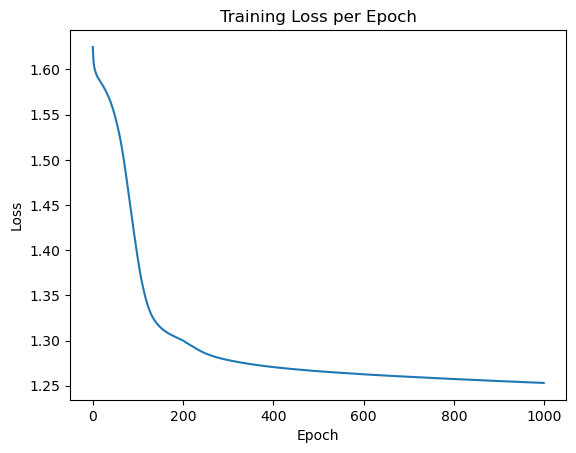

In [26]:
plot_loss(loss_list)

In [27]:
evaluate_actor(actor, X_pt_train_tensor, y_pt_train_tensor, X_pt_test_tensor, y_pt_test_tensor)

Train Accuracy: 0.6296869390050551
Test Accuracy: 0.6293608530432241


(0.6296869390050551, 0.6293608530432241)

## Collect Initial ACTOR Data

In [28]:
import Bot1

In [43]:
file_name = 'Data/Model3/actor_data.csv'

In [30]:
%run Bot1.ipynb

In [31]:
grid, open_cells = create_grid() # Fixed grid orientation

In [32]:
def is_valid(x, y, move, grid, open_cells):
    if move == 'up' and (x, y + 1) in open_cells:
        return True
    elif move == 'down' and (x, y - 1) in open_cells:
        return True
    elif move == 'left' and (x - 1, y) in open_cells:
        return True
    elif move == 'right' and (x + 1, y) in open_cells:
        return True
    elif move == 'stay':
        return True
    else:
        return False

In [33]:
def predict_to_move(bot, prediction):
    next_move = bot
    
    if prediction == 0:
        next_move = (bot[0], bot[1] + 1)
    elif prediction == 1:
        next_move = (bot[0], bot[1] - 1)
    elif prediction == 2:
        next_move = (bot[0] - 1, bot[1])
    elif prediction == 3:
        next_move = (bot[0] + 1, bot[1])
    else:
        next_move = bot
        
    return next_move

In [34]:
def create_valid_matrix(X):
    global grid, open_cells
    directions = ['up', 'down', 'left', 'right', 'stay']
    valid_list = []
    for i in range(len(X)):
        x, y = X.iloc[i, 0], X.iloc[i, 1]
        validity_for_each_direction = [is_valid(x, y, move, grid, open_cells) for move in directions]
        valid_list.append(validity_for_each_direction)

    valid_array = np.array(valid_list)
    return valid_array

In [35]:
def determine_probabilities(bot, matrix):
    directions = {'up': (bot[0], bot[1] - 1), 
                  'down': (bot[0], bot[1] + 1), 
                  'left': (bot[0] - 1, bot[1]), 
                  'right': (bot[0] + 1, bot[1]),
                  'stay': bot}
    return [matrix.get(directions[direction], 0) for direction in ['up', 'down', 'left', 'right', 'stay']]

In [36]:
def determine_d_crew(ship, bot, alpha, d_lookup_table, crew_list, crew_matrix, open_cells):
    directions = {'up': (bot[0], bot[1] - 1), 
                  'down': (bot[0], bot[1] + 1), 
                  'left': (bot[0] - 1, bot[1]), 
                  'right': (bot[0] + 1, bot[1]),
                  'stay': bot}
    
    direction_values = set(directions.values())
    
    filtered_crew_matrix = {k: v for k, v in crew_matrix.items() if k not in direction_values}
    
    if filtered_crew_matrix:
        max_crew_cell = max(filtered_crew_matrix, key=filtered_crew_matrix.get)
    else:
        return [0] * 5, d_lookup_table
        
    d_list = []
    
    for direction in ['up', 'down', 'left', 'right', 'stay']:
        if (directions[direction] in open_cells or directions[direction] == bot) and directions[direction] not in crew_list:
            _, d_lookup_table = crew_sensor(ship, directions[direction], alpha, d_lookup_table, crew_list)
            d_dict = d_lookup_table.get(directions[direction])
            d_list.append(1 / d_dict[max_crew_cell[0], max_crew_cell[1]])
        else:
            d_list.append(0)
    
    return d_list, d_lookup_table

In [55]:
def determine_d_alien(ship, bot, alpha, d_lookup_table, alien_list, crew_list, alien_matrix, open_cells):
    directions = {'up': (bot[0], bot[1] - 1), 
                  'down': (bot[0], bot[1] + 1), 
                  'left': (bot[0] - 1, bot[1]), 
                  'right': (bot[0] + 1, bot[1]),
                  'stay': bot}
    
    direction_values = set(directions.values())
    
    filtered_alien_matrix = {k: v for k, v in alien_matrix.items() if k not in direction_values}
    
    if filtered_alien_matrix:
        max_alien_cell = max(filtered_alien_matrix, key=filtered_alien_matrix.get)
    else:
        return [0] * 5, d_lookup_table
        
    d_list = []
    
    for direction in ['up', 'down', 'left', 'right', 'stay']:
        if (directions[direction] in open_cells or directions[direction] == bot) and directions[direction] not in crew_list and directions[direction] not in alien_list:
            _, d_lookup_table = crew_sensor(ship, directions[direction], alpha, d_lookup_table, crew_list)
            d_dict = d_lookup_table.get(directions[direction])
            d_list.append(1 / d_dict[max_alien_cell[0], max_alien_cell[1]])
        else:
            d_list.append(0)
    
    return d_list, d_lookup_table

In [49]:
def predict_with_params(actor, bot, alien_matrix, crew_matrix, d_crew, d_alien, alien_detected, crew_detected):
    alien_probs = determine_probabilities(bot, alien_matrix)
    crew_probs = determine_probabilities(bot, crew_matrix)
    
    X = pd.DataFrame([{
        'bot_x': bot[0],
        'bot_y': bot[1],
            
        'alien_up': alien_probs[0],
        'alien_down': alien_probs[1],
        'alien_left': alien_probs[2],
        'alien_right': alien_probs[3],
        'alien_stay': alien_probs[4],
            
        'crew_up': crew_probs[0],
        'crew_down': crew_probs[1],
        'crew_left': crew_probs[2],
        'crew_right': crew_probs[3],
            
        'd_crew_up': np.float32(d_crew[0]),
        'd_crew_down': np.float32(d_crew[1]),
        'd_crew_left': np.float32(d_crew[2]),
        'd_crew_right': np.float32(d_crew[3]),
        'd_crew_stay': np.float32(d_crew[4]),
        
#         'd_alien_up': np.float32(d_alien[0]),
#         'd_alien_down': np.float32(d_alien[1]),
#         'd_alien_left': np.float32(d_alien[2]),
#         'd_alien_right': np.float32(d_alien[3]),
#         'd_alien_stay': np.float32(d_alien[4]),
            
        'alien_detected': 1 if alien_detected else 0,
        'crew_detected': 1 if crew_detected else 0,
    }])
    
#     X = pd.DataFrame([{
#         'bot_x': bot[0],
#         'bot_y': bot[1],

#         'alien_up': alien_probs[0],
#         'alien_down': alien_probs[1],
#         'alien_left': alien_probs[2],
#         'alien_right': alien_probs[3],
#         'alien_stay': alien_probs[4],

#         'crew_up': crew_probs[0],
#         'crew_down': crew_probs[1],
#         'crew_left': crew_probs[2],
#         'crew_right': crew_probs[3],

#         'alien_detected': 1 if alien_detected else 0,
#         'crew_detected': 1 if crew_detected else 0,
#     }], columns=['bot_x', 'bot_y', 'alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay', 'crew_up', 'crew_down', 'crew_left', 'crew_right', 'alien_detected', 'crew_detected'])
    
    valid = create_valid_matrix(X)
    
    crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right']
    X['sum_crew'] = X[crew_columns].sum(axis=1)

    for col in crew_columns:
        X.loc[X['sum_crew'] != 0, col] = X[col] / X['sum_crew']

    X.drop('sum_crew', axis=1, inplace=True)
    
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    
    prediction = predict_action(actor, X_tensor, valid)
    next_move = predict_to_move(bot, prediction)
    
    return next_move

In [50]:
def Actor_Bot1(k, alpha, max_iter, timeout, actor):
    global grid, open_cells
    
    grid, open_cells = reset_grid(grid, open_cells)
    bot, ship, open_cells = place_bot(grid, open_cells)

    crew_list = []
    alien_list = []
    d_lookup_table = {}
    
    data_log = [] # Data Log Initialization

    crew_list, ship = place_crew(ship, open_cells, crew_list)
    alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

    alien_matrix = initialize_alienmatrix(open_cells, bot, k)
    crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
    
    alien_detected = alien_sensor(alien_list, bot, k) # Initially Run Alien Sensor
    crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Initially Run Crew Sensor
    
    win_count = 0
    loss_count = 0
    move = 0
    win_move_count = []
    marker = 0
    
    df = pd.DataFrame()
    cur_df = pd.DataFrame()
    
    while (win_count + loss_count) < max_iter:
        neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
        open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
        open_moves.append(bot)
        
        # Data Collection Process
        
        alien_probs = determine_probabilities(bot, alien_matrix)
        crew_probs = determine_probabilities(bot, crew_matrix)
        d_crew, d_lookup_table = determine_d_crew(ship, bot, alpha, d_lookup_table, crew_list, crew_matrix, open_cells) # Find shortest distance from highest probability crew cell to all neighbors
        d_alien, d_lookup_table = determine_d_alien(ship, bot, alpha, d_lookup_table, alien_list, crew_list, alien_matrix, open_cells) # Find shortest distance from highest probability alien cell to all neighbors
        
        next_move = predict_with_params(actor, bot, alien_matrix, crew_matrix, d_crew, d_alien, alien_detected, crew_detected) # Predict using trained network
        
        crew_probs.pop()
        
        if sum(crew_probs) > 0:
            crew_probs = [c / sum(crew_probs) for c in crew_probs]
        
        # Convert relative move to string      
        if next_move[0] > bot[0]:
            next_move_str = 'right'
        elif next_move[0] < bot[0]:
            next_move_str = 'left'
        elif next_move[1] > bot[1]:
            next_move_str = 'up'
        elif next_move[1] < bot[1]:
            next_move_str = 'down'
        else:
            next_move_str = 'stay'
        
        actions = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'stay': 4}
        best_move_encoded = actions[next_move_str]
        
        log_entry = {
            'bot_x': bot[0],
            'bot_y': bot[1],
            
            'alien_up': alien_probs[0],
            'alien_down': alien_probs[1],
            'alien_left': alien_probs[2],
            'alien_right': alien_probs[3],
            'alien_stay': alien_probs[4],
            
            'crew_up': crew_probs[0],
            'crew_down': crew_probs[1],
            'crew_left': crew_probs[2],
            'crew_right': crew_probs[3],
            
            'd_crew_up': np.float32(d_crew[0]),
            'd_crew_down': np.float32(d_crew[1]),
            'd_crew_left': np.float32(d_crew[2]),
            'd_crew_right': np.float32(d_crew[3]),
            'd_crew_stay': np.float32(d_crew[4]),
            
#             'd_alien_up': np.float32(d_alien[0]),
#             'd_alien_down': np.float32(d_alien[1]),
#             'd_alien_left': np.float32(d_alien[2]),
#             'd_alien_right': np.float32(d_alien[3]),
#             'd_alien_stay': np.float32(d_alien[4]),
            
            'alien_detected': 1 if alien_detected else 0,
            'crew_detected': 1 if crew_detected else 0,
            
            'chosen_action': best_move_encoded
            
            'successful': 0
        }
#         data_log.append(log_entry)

        cur_df = cur_df.append(log_entry, ignore_index=True)

#         log_entry = {
#             'bot_x': bot[0],
#             'bot_y': bot[1],
            
#             'alien_up': alien_probs[0],
#             'alien_down': alien_probs[1],
#             'alien_left': alien_probs[2],
#             'alien_right': alien_probs[3],
#             'alien_stay': alien_probs[4],
            
#             'crew_up': crew_probs[0],
#             'crew_down': crew_probs[1],
#             'crew_left': crew_probs[2],
#             'crew_right': crew_probs[3],
            
#             'alien_detected': 1 if alien_detected else 0,
#             'crew_detected': 1 if crew_detected else 0,
            
#             'chosen_action': best_move_encoded
#         }
#         data_log.append(log_entry)
        
        prev_win_count = win_count
        bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
        move += 1

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"ACTOR captured! Win Count: {win_count}, Loss Count: {loss_count}")
            
            df = df.append(cur_df, ignore_index=True)
            cur_df.drop(cur_df.index, axis=0, inplace=True)
            cur_df.drop(cur_df.columns, axis=1, inplace=True)
            
            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue

        if win_count > prev_win_count:
            print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
            
            cur_df['successful'] = 1
            df = df.append(cur_df, ignore_index=True)
            cur_df.drop(cur_df.index, axis=0, inplace=True)
            cur_df.drop(cur_df.columns, axis=1, inplace=True)
            
            win_move_count.append(move)
            move = 0
            d_lookup_table = {}
            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
        print(f"ACTOR: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

        alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

        # Move bot to optimal neighbor
        marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"ACTOR captured! Win Count: {win_count}, Loss Count: {loss_count}")

            df = df.append(cur_df, ignore_index=True)
            cur_df.drop(cur_df.index, axis=0, inplace=True)
            cur_df.drop(cur_df.columns, axis=1, inplace=True)
            
            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue
        
        alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
        alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
        crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
        alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

        crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor
    
    df = df.append(cur_df, ignore_index=True)
        
#     df = pd.DataFrame(data_log)
    df.to_csv(file_name, mode='w', index=False, header=True)

    return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [51]:
def Actor_Bot1_Simulation(alpha_values, k_values, max_iter, timeout, num_simulations, actor):
    avg_rescue_moves_mbot1 = {k: [] for k in k_values}
    prob_crew_rescue_mbot1 = {k: [] for k in k_values}
    avg_crew_saved_mbot1 = {k: [] for k in k_values}

    for k in k_values:
        for alpha in alpha_values:
            total_metric1_mbot1, total_metric2_mbot1, total_metric3_mbot1 = 0, 0, 0
            
            for i in range(num_simulations):
                metric1_mbot1, metric2_mbot1, metric3_mbot1 = Actor_Bot1(k, alpha, max_iter, timeout, actor)

                total_metric1_mbot1 += metric1_mbot1
                total_metric2_mbot1 += metric2_mbot1
                total_metric3_mbot1 += metric3_mbot1

            avg_metric1_mbot1 = total_metric1_mbot1 / num_simulations
            avg_metric2_mbot1 = total_metric2_mbot1 / num_simulations
            avg_metric3_mbot1 = total_metric3_mbot1 / num_simulations

            print(f"ACTOR: k={k}, Alpha={alpha}\nAverage Rescue Moves={avg_metric1_mbot1}\nProbability of Crew Rescue={avg_metric2_mbot1}\nAverage Crew Saved={avg_metric3_mbot1}\n")
            
            avg_rescue_moves_mbot1[k].append(avg_metric1_mbot1)
            prob_crew_rescue_mbot1[k].append(avg_metric2_mbot1)
            avg_crew_saved_mbot1[k].append(avg_metric3_mbot1)

    return avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1

In [52]:
def test_simulation_actor(alpha_values, k_values, max_iter, timeout, num_simulations, actor):
    avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1 = Actor_Bot1_Simulation(alpha_values, k_values, max_iter, timeout, num_simulations, actor)

    prob_crew_rescue_mbot1 = {k: [round(prob, 3) for prob in probs] for k, probs in prob_crew_rescue_mbot1.items()}

    print(f"ACTOR:\nAverage Rescue Moves = {avg_rescue_moves_mbot1}\nProbability of Crew Rescue = {prob_crew_rescue_mbot1}\nAverage Crew Saved = {avg_crew_saved_mbot1}\n")
    
    return avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1

In [57]:
alpha_values = [0.004]
k_values = [3]
max_iter = 2
timeout = 10000
num_simulations = 1

In [58]:
metric1_mbot1, metric2_mbot1, metric3_mbot1 = test_simulation_actor(alpha_values, k_values, max_iter, timeout, num_simulations, actor)

ACTOR: (18, 5), Crew: [(27, 24)], Aliens: [(3, 28)]
ACTOR: (18, 4), Crew: [(27, 24)], Aliens: [(3, 28)]
ACTOR: (18, 3), Crew: [(27, 24)], Aliens: [(3, 27)]
ACTOR: (18, 3), Crew: [(27, 24)], Aliens: [(3, 27)]
ACTOR: (18, 3), Crew: [(27, 24)], Aliens: [(3, 27)]
ACTOR: (18, 3), Crew: [(27, 24)], Aliens: [(3, 27)]
ACTOR: (18, 3), Crew: [(27, 24)], Aliens: [(3, 27)]
ACTOR: (19, 3), Crew: [(27, 24)], Aliens: [(3, 26)]
ACTOR: (19, 2), Crew: [(27, 24)], Aliens: [(4, 26)]
ACTOR: (19, 1), Crew: [(27, 24)], Aliens: [(4, 26)]
ACTOR: (20, 1), Crew: [(27, 24)], Aliens: [(4, 25)]
ACTOR: (21, 1), Crew: [(27, 24)], Aliens: [(4, 25)]
ACTOR: (22, 1), Crew: [(27, 24)], Aliens: [(4, 26)]
ACTOR: (22, 0), Crew: [(27, 24)], Aliens: [(4, 25)]
ACTOR: (21, 0), Crew: [(27, 24)], Aliens: [(3, 25)]
ACTOR: (22, 0), Crew: [(27, 24)], Aliens: [(4, 25)]
ACTOR: (22, 0), Crew: [(27, 24)], Aliens: [(4, 25)]
ACTOR: (23, 0), Crew: [(27, 24)], Aliens: [(4, 25)]
ACTOR: (24, 0), Crew: [(27, 24)], Aliens: [(3, 25)]
ACTOR: (24, 

ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(7, 21)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(6, 21)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(5, 21)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(5, 21)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(5, 22)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(5, 23)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(5, 22)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(5, 22)]
ACTOR: (28, 1), Crew: [(27, 24)], Aliens: [(4, 22)]
ACTOR: (28, 0), Crew: [(27, 24)], Aliens: [(5, 22)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(5, 21)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(4, 21)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(4, 22)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(4, 22)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(4, 21)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(3, 21)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(4, 21)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(4, 22)]
ACTOR: (29, 0), Crew: [(27, 24)], Aliens: [(5, 22)]
ACTOR: (28, 

ACTOR: (28, 5), Crew: [(27, 24)], Aliens: [(7, 25)]
ACTOR: (28, 6), Crew: [(27, 24)], Aliens: [(7, 25)]
ACTOR: (29, 6), Crew: [(27, 24)], Aliens: [(8, 25)]
ACTOR: (29, 5), Crew: [(27, 24)], Aliens: [(7, 25)]
ACTOR: (29, 4), Crew: [(27, 24)], Aliens: [(7, 25)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(7, 26)]
ACTOR: (29, 2), Crew: [(27, 24)], Aliens: [(7, 26)]
ACTOR: (29, 2), Crew: [(27, 24)], Aliens: [(6, 26)]
ACTOR: (29, 2), Crew: [(27, 24)], Aliens: [(5, 26)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(4, 26)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(5, 26)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(4, 26)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(4, 26)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(3, 26)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(3, 25)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(2, 25)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(2, 25)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(3, 25)]
ACTOR: (29, 3), Crew: [(27, 24)], Aliens: [(3, 24)]
ACTOR: (29, 

ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(7, 19)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(7, 19)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(7, 18)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(8, 18)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(7, 18)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(8, 18)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(7, 18)]
ACTOR: (28, 3), Crew: [(27, 24)], Aliens: [(7, 18)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(7, 19)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(7, 18)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(6, 18)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(6, 19)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(5, 19)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(4, 19)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(4, 20)]
ACTOR: (27, 3), Crew: [(27, 24)], Aliens: [(4, 19)]
ACTOR: (27, 2), Crew: [(27, 24)], Aliens: [(3, 19)]
ACTOR: (27, 2), Crew: [(27, 24)], Aliens: [(3, 19)]
ACTOR: (27, 2), Crew: [(27, 24)], Aliens: [(3, 19)]
ACTOR: (27, 

ACTOR: (24, 15), Crew: [(16, 4)], Aliens: [(8, 19)]
ACTOR: (24, 14), Crew: [(16, 4)], Aliens: [(9, 19)]
ACTOR: (23, 14), Crew: [(16, 4)], Aliens: [(9, 20)]
ACTOR: (24, 14), Crew: [(16, 4)], Aliens: [(8, 20)]
ACTOR: (24, 15), Crew: [(16, 4)], Aliens: [(8, 20)]
ACTOR: (24, 14), Crew: [(16, 4)], Aliens: [(8, 19)]
ACTOR: (23, 14), Crew: [(16, 4)], Aliens: [(7, 19)]
ACTOR: (23, 13), Crew: [(16, 4)], Aliens: [(7, 18)]
ACTOR: (23, 12), Crew: [(16, 4)], Aliens: [(8, 18)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 17)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 16)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 17)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 16)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(9, 16)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(9, 15)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 15)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 14)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 15)]
ACTOR: (24, 12), Crew: [(16, 4)], Aliens: [(8, 16)]
ACTOR: (24, 

In [ ]:
print(metric1_mbot1, metric2_mbot1, metric3_mbot1)